## Tallo analysis - filtering by tropical PFTs 

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### CSV files from the  Tallo github:

Main csv with dbh,  height, CA: https://github.com/selva-lab-repo/TALLO/tree/main/DB

Additional csv with biome info: https://github.com/selva-lab-repo/TALLO/tree/main/Jucker%20et%20al.%202022 - (Tallo_environment.csv)

In [2]:
df = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo.csv')
df_env = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_environment.csv')


#### add biome column to main data frame

In [3]:
df_tallo = pd.merge(df, df_env, on='tree_id', how='outer')
#print(df_tallo.head(3))

#### Filter biomes to only keep tropical forest and savanna trees

In [4]:
print(df_tallo['biome'].unique())

['Boreal/montane forest' 'Tropical rain forest'
 'Temperate broadleaf forest' 'Tropical savanna' 'Tropical dry forest'
 'Temperate grassland' 'Temperate conifer forest' 'Mediterranean woodland'
 'Dryland' 'Mangrove']


In [5]:
df_trop = df_tallo.loc[df_tallo['biome'].isin(['Tropical rain forest', 'Tropical savanna', 'Tropical dry forest'])]

#### Filter to only keep angiospermms (FATES doesn't have needleleaf tropical trees)
This discards 1921 trees,  but keeps 174,227

In [6]:
x = df_trop.groupby('division').count()
x['species']

division
Angiosperm    174195
Gymnosperm      1921
Name: species, dtype: int64

In [7]:
df_trop = df_trop.loc[df_trop['division'] == 'Angiosperm']

#### Filter by canopy trees
Only keep species that have a maximum dbh greater 30 cm 

In [8]:
max_dbhs = df_trop.pivot_table(index='species', values='stem_diameter_cm', aggfunc='max')
# get the names of species where max dbh > 30
canopy_species = max_dbhs[max_dbhs['stem_diameter_cm'] > 30]
canopy_names = canopy_species.index

In [9]:
df_trop = df_trop.loc[df_trop['species'].isin(canopy_names)]

#### Organizing columns 

In [10]:
# only keep relevant columns
keep = ['species', 'latitude', 'longitude', 'stem_diameter_cm', 'height_m', 'height_outlier', 'crown_radius_m', 
       'crown_radius_outlier', 'realm', 'biome', 'family']

df_trop = df_trop[keep]

# make a crown area column
df_trop['crown_area']  = np.pi * df_trop['crown_radius_m']**2 
# rename them 
new_col_names = {'stem_diameter_cm': 'dbh', 'height_m': 'height'}
df_trop.rename(columns=new_col_names, inplace=True)


In [11]:
# Save the csv file 
df_trop.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv', index=False)


#### Plot them  - by realm

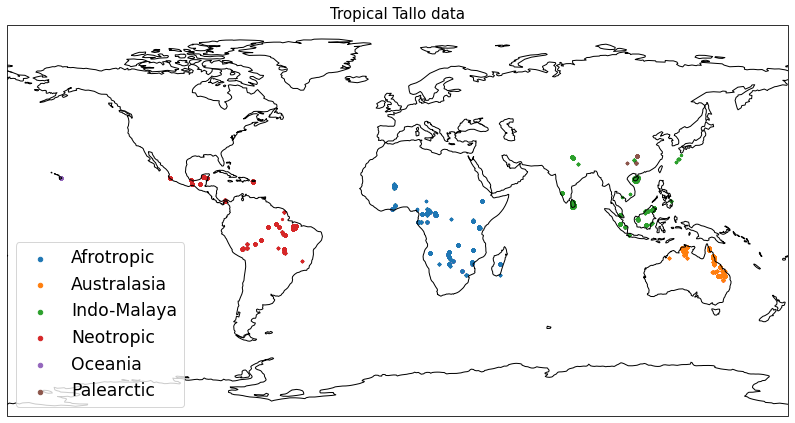

In [12]:
fig1, ax = plt.subplots(nrows=1, ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(14,8))

for cat, d in df_trop.groupby('realm'):
    ax.scatter(d['longitude'], d['latitude'], label=cat,  s=5, marker ='o', transform=ccrs.PlateCarree())

ax.set_title('Tropical Tallo data', fontsize=15)
ax.coastlines()
ax.set_global()

ax.legend(loc='lower left', fontsize='xx-large', markerscale=2.0)

#### Plot them by biome

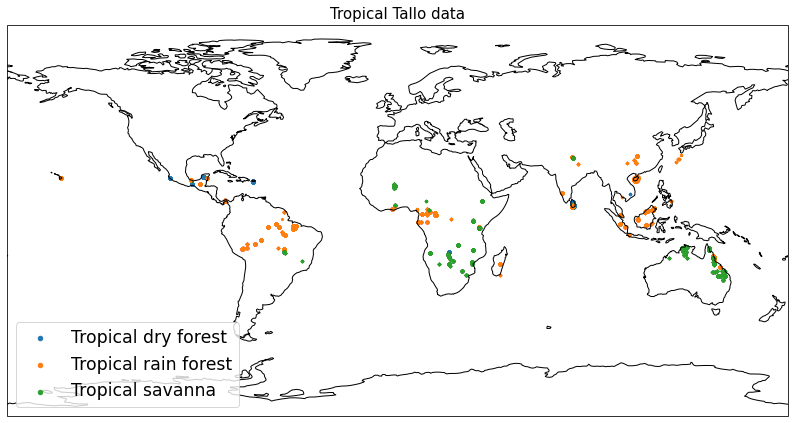

In [13]:
fig1, ax = plt.subplots(nrows=1, ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(14,8))

for cat, d in df_trop.groupby('biome'):
    ax.scatter(d['longitude'], d['latitude'], label=cat,  s=5, marker ='o', transform=ccrs.PlateCarree())

ax.set_title('Tropical Tallo data', fontsize=15)
ax.coastlines()
ax.set_global()

ax.legend(loc='lower left', fontsize='xx-large', markerscale=2.0)

#### Sample sizes - total number of observations
For height and crown area : 

In [14]:
x = df_trop.groupby(['realm']).count()
x[['height','crown_area']]

,height,crown_area
realm,,
Afrotropic,11937,11176
Australasia,34370,1518
Indo-Malaya,51537,37329
Neotropic,34044,24543
Oceania,501,0
Palearctic,808,805


In [15]:
x = df_trop.groupby(['biome']).count()
x[['height','crown_area']]

,height,crown_area
biome,,
Tropical dry forest,14965,7441
Tropical rain forest,105883,60969
Tropical savanna,12349,6961


#### Sample sizes - by species 
For height and  crown area : 

In [16]:
df_trop.groupby('realm')['species'].nunique().reset_index(name='N_species')

,realm,N_species
0,Afrotropic,443
1,Australasia,302
2,Indo-Malaya,803
3,Neotropic,515
4,Oceania,2
5,Palearctic,33


#### sample size number  of sites in the tropics

In [17]:
unique_sites = df_trop.groupby(['latitude', 'longitude']).size().reset_index(name='count')
print(unique_sites)

      latitude  longitude  count
0      -27.415    149.938     16
1      -27.415    149.939     23
2      -27.400    149.900     45
3      -25.789    147.395     38
4      -25.789    147.396     37
...        ...        ...    ...
1616    29.262     80.653      3
1617    29.264     80.647      2
1618    29.270     80.657      3
1619    29.767    110.083    739
1620    30.320    130.430      2

[1621 rows x 3 columns]


In [18]:
x = df_trop.groupby(['realm', 'biome']).count()
x[['height','crown_area']]

height  crown_area
realm       biome                                   
Afrotropic  Tropical dry forest      304         304
            Tropical rain forest    6475        5597
            Tropical savanna        5158        5275
Australasia Tropical rain forest   27578          11
            Tropical savanna        6792        1507
Indo-Malaya Tropical dry forest     3796           0
            Tropical rain forest   47532       37329
            Tropical savanna         209           0
Neotropic   Tropical dry forest    10865        7137
            Tropical rain forest   22989       17227
            Tropical savanna         190         179
Oceania     Tropical rain forest     501           0
Palearctic  Tropical rain forest     808         805